# Evaluate Easer on dataset
Created by Andy Smet, Kristof Egghe


use Easer on each random split of the data

Qualitative Evaluation on the predictions of last the last split

In [ ]:
allData=True


path="/home/andy/Desktop/AI_Project/"
# path="./drive/MyDrive/AI Project/"



# goodreads_path = '/home/andy/Desktop/AI_Project/datasets/Goodreads/'
folds_path=path+"datasets/"

if allData:
  interactions_csv_path = path+"datasets/AllDataPreprocessed_interactions.csv"
  consgroup_path=path+"datasets/AllDataConsGroupdict.pickle"
  reversegroup_path=path+"datasets/AllDataReverseGroupdict.pickle"
  groupdict_path=path+"datasets/AllDataGroupdict.pickle"
  userdic_path=path+"datasets/AllDataUser_dic.pickle"
  books_df_g_path=path+"datasets/books_df_grouped.csv"
else:
  interactions_csv_path = path+"datasets/TestDataPreprocessed_interactions.csv"
  consgroup_path=path+"datasets/TestDataConsGroupdict.pickle"
  reversegroup_path=path+"datasets/TestDataReverseGroupdict.pickle"
  groupdict_path=path+"datasets/TestDataGroupdict.pickle"
  userdic_path=path+"datasets/TestDataUser_dic.pickle"
  books_df_g_path=path+"datasets/books_df_grouped.csv"


In [ ]:
# Mount google drive
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:

#Embarrassingly Shallow Autoencoder
from scipy.sparse import find
import itertools
import re
import numpy as np
class Ease():
    def __init__(self, K=10, l=1000):
        #how many predictions to make
        self.K = K
        #lambda L2 regularization term

        self.l = l
        #weight matrix B
        self.B = None
        #threshold for corrcoeff matrix in fit
        self.threshold = 0.65
        #new diag that helps for adjusted self-similarity scores
        self.newDiag = []

    def fit(self, X):
        #implementation of sparse inverse calculations
        #get ItemxItem gram matirx G
        G = (X.T @ X).toarray().astype(np.float32)
        print("multiplication klaar")
        #calculate corrcoef matrix on G
        c=np.corrcoef(G).astype(np.float32)
        c = np.nan_to_num(c)
        
        print("corr klaar")
        #set threshold for maximal size of blocks
        maxi=1000
        # threshold=0.3 -> 850 items worden gerecommend
        # maxi=1500
        #first set all items in the corrcoef matrix that are above a threshold to 1
        for row in c.T:
          l=list(reversed(np.argsort(row)))[:maxi]
          for i in l:
            if row[i]>self.threshold:
              row[i]=1
            else:
              break
        #binarize corrcoef matrix
        A=np.where(c==1, 1, 0)
        

        #get list of indices in descending order of column sums
        res=A.sum(axis=0)
        
        l=np.array(list(reversed(np.argsort(res))))
        setje=set()
        #iterate over indices and generate submatrices
        spars=scipy.sparse.lil_matrix(G.shape)
        for i in l:
          if i in setje:
              continue
          #get itemindexes where element == 0
          col=A[:,i]
          itemindexes=np.where(col==1)
          #construct submatrix
          sub=G[np.ix_(itemindexes[0],itemindexes[0])]
          diag=scipy.sparse.dia_matrix(sub.shape)
          #set submatrixs diagonal to lambda + submatrix
          diag.setdiag([self.l]*sub.shape[0])
          sub2=(sub+diag)
          #calculate inverse and set diagonal to 0 (self-similarity)
          P=np.linalg.inv(sub2)
          B=-P/P.diagonal()
         
          
          np.fill_diagonal(B,0)
          # store values in sparse matrix
          for i in itertools.product(range(B.shape[0]),range(B.shape[0])):
            i1=i[0]
            j1=i[1]
            spars[itemindexes[0][i1],itemindexes[0][j1]]=B[i1,j1]
          for j in itemindexes[0]:
              setje.add(j)
        # d = [0 if len(reverseGroupdic[key])==1 else similarityScoreDic[key] for key in similarityScoreDic]
        spars.setdiag(self.newDiag)
        self.B = spars.toarray()
    def predict(self, X, firstUserID):
        #iterate over all users and extract top 10 items after multiplying interaction matrix with weight matrix B

        S = X*self.B
        users = set(X.nonzero()[0])
        
        print(firstUserID)
      
        U, I, V = [], [], []
        real_groups=list(cons_group_dic.keys())
        for user in users:
            history_of_user=sessions_df.loc[sessions_df['user_id']==user+firstUserID].history.item()
            U.extend([user] * self.K)

            a = []
            #
            # check history of user and penalize volumes according to time
            for i in range(len(S[user])):
              try:
                lastViewedIndex = (len(history_of_user) - 1 - history_of_user[::-1].index(i))
              except:
                lastViewedIndex = len(history_of_user)
              if i not in history_of_user or (len(reverseGroupdic[real_groups[i]]) > 1 and len(re.split(' Volume| Vol\.| vol\.| #', books_df_g.loc[books_df_g['group_id'] == real_groups[i]].title.item())) > 1):
                a.append(S[user][i]*((lastViewedIndex/len(history_of_user))**2)) 
              else:
                a.append(-self.l*2)
            #extract top K items 
            items = np.array(a).argsort()[-self.K:][::-1]
            I.extend(items)
            V.extend(S[user][items])

        score_matrix = scipy.sparse.csr_matrix((V, (U, I)), shape=X.shape).astype(np.float32)
        print("predict klaar")
        return score_matrix



In [ ]:
from scipy.sparse import vstack
from sklearn.model_selection import KFold
import sklearn.metrics
import statistics
import pickle
import pandas as pd
with open(consgroup_path, 'rb') as f:
    cons_group_dic= pickle.load(f)
with open(groupdict_path, 'rb') as f:
    groupdic= pickle.load(f)
with open(reversegroup_path, 'rb') as f:
    reverseGroupdic= pickle.load(f)
with open(userdic_path, 'rb') as f:
    userdic= pickle.load(f)

#set parameters
sessions_df=0
books_df_g=pd.read_csv(books_df_g_path)
lambda_=1000
threshold=0.9
# books_df_g["group_id"]=range(0,len(books_df_g))


def recall_easer_evaluation(model,K):
  #sessions_df is used in Ease.predict, so we set it in this function
  global sessions_df

  ease = model
  recalls5 = []
  ndcgs5 = []
  recalls10 = []
  ndcgs10 = []
  y_pred_total=None
  for s in range(1,6):
    if allData:
      sessions_df = pd.read_csv(folds_path+"AllDatafold"+str(s)+".csv")
    else:
      sessions_df = pd.read_csv(folds_path+"TestDatafold"+str(s)+".csv")
    #initialize sessions_df correctly by changing string to lists and applying the userdic to make users sequential and groupdics to make item_ids into sequential group_ids
    sessions_df['user_id'] = sessions_df.user_id.apply(lambda x:int(userdic[int(x)]))

    sessions_df['history'] = sessions_df.history.apply(lambda x:[int(cons_group_dic[groupdic[int(y)]]) if y else y for y in x[1:-1].split(',')])
    sessions_df['future'] = sessions_df.future.apply(lambda x:[int(cons_group_dic[groupdic[int(y)]]) if y else y for y in x[1:-1].split(',')])
    shape = (sessions_df['user_id'].max() +1, len(cons_group_dic))

    ease.newDiag = get_newDiag(sessions_df,shape)
    #create train and true matrix and fit the model
    train_x = create_sparse_matrix(sessions_df, column='history', shape=shape)
    y_true = create_sparse_matrix(sessions_df, column='future', shape=shape)    
    ease.threshold = threshold
    ease.l=lambda_
    ease.fit(train_x)
    #initialize params for batch processing of users and reset the ndcgs and recalls to 0
    interval=int(train_x.shape[0]/20)
    true_ndcg5=0
    true_recall5=0
    true_ndcg10=0
    true_recall10=0
    #y_pred total is the predictions stacked ontop of eachother
    y_pred_total = scipy.sparse.csr_matrix((0,train_x.shape[1])).astype(np.float32)
    # iterate over 20 batches to calculate ndcg and recall
    for j in range(20-1):
      #create predict and truth batch and make recommendations
      predict_split=train_x[np.ix_(list(range(interval*j,interval*(j+1))),list(range(train_x.shape[1])))]
      true_split=y_true[np.ix_(list(range(interval*j,interval*(j+1))),list(range(train_x.shape[1])))]
      y_pred = ease.predict(predict_split, interval*j)
      y_pred_total = vstack((y_pred_total, y_pred))
      #calculate recall@K=10
      scores = scipy.sparse.lil_matrix(y_pred.shape)
      scores[y_pred.multiply(true_split).astype(bool)] = 1
      scores = scores.tocsr()
      scores = sparse_divide_nonzero(scores, scipy.sparse.csr_matrix(true_split.sum(axis=1))).sum(axis=1)
      true_recall10+=scores.mean()*(interval/train_x.shape[0])
      #calculate recall@K=5 (couldn't find a better way)
      y_predD=y_pred.toarray()
      rows=np.asarray((-y_predD).argsort()[:,:5])
      y_pred5 = scipy.sparse.lil_matrix(y_pred.shape)
      #create top5 predictions from top10 predictions
      for row in range(len(rows)):
        for ind in rows[row]:
          y_pred5[row,ind]=y_pred[row,ind]
      scores5 = scipy.sparse.lil_matrix(y_pred.shape)

      scores5[y_pred5.multiply(true_split).astype(bool)] = 1
      scores5 = scores5.tocsr()
      scores5 = sparse_divide_nonzero(scores5, scipy.sparse.csr_matrix(true_split.sum(axis=1))).sum(axis=1)
      true_recall5+=scores5.mean()*(interval/train_x.shape[0])
      #calculate ndcg@5 and 10

      ndcg10 = sklearn.metrics.ndcg_score(true_split.toarray(), y_pred.toarray(), k=10)
      true_ndcg10+=ndcg10*(interval/train_x.shape[0])
      ndcg5 = sklearn.metrics.ndcg_score(true_split.toarray(), y_pred.toarray(), k=5)
      true_ndcg5+=ndcg5*(interval/train_x.shape[0])
    #do the 20th and last predict and calculate recall and ndcg
    predict_split=train_x[np.ix_(list(range(interval*19,train_x.shape[0])),list(range(train_x.shape[1])))]
    true_split=y_true[np.ix_(list(range(interval*19,train_x.shape[0])),list(range(train_x.shape[1])))]
    y_pred = ease.predict(predict_split, interval*19)
    y_pred_total = vstack((y_pred_total, y_pred))
    scores = scipy.sparse.lil_matrix(y_pred.shape)
    scores[y_pred.multiply(true_split).astype(bool)] = 1
    scores = scores.tocsr()
    scores = sparse_divide_nonzero(scores, scipy.sparse.csr_matrix(true_split.sum(axis=1))).sum(axis=1)
    true_recall10+=scores.mean()*(interval/train_x.shape[0])

    y_predD=y_pred.toarray()
    rows=np.asarray((-y_predD).argsort()[:,:5])
    y_pred5 = scipy.sparse.lil_matrix(y_pred.shape)
    for row in range(len(rows)):
      for ind in rows[row]:
        y_pred5[row,ind]=y_pred[row,ind]
    scores5 = scipy.sparse.lil_matrix(y_pred.shape)

    scores5[y_pred5.multiply(true_split).astype(bool)] = 1
    scores5 = scores5.tocsr()
    scores5 = sparse_divide_nonzero(scores5, scipy.sparse.csr_matrix(true_split.sum(axis=1))).sum(axis=1)
    true_recall5+=scores5.mean()*(interval/train_x.shape[0])

    ndcg10 = sklearn.metrics.ndcg_score(true_split.toarray(), y_pred.toarray(), k=10)
    true_ndcg10+=ndcg10*(interval/train_x.shape[0])
    ndcg5 = sklearn.metrics.ndcg_score(true_split.toarray(), y_pred.toarray(), k=5)
    true_ndcg5+=ndcg5*(interval/train_x.shape[0])
    #write intermediate result to file and append the metrics to theire list
    f = open(path+"Evaluation.txt", "a")
    f.write("recall @ {}: {:.4f}, ndcg: {:.4f} params lambda:{}, threshold={}, split={} \n ".format(10,true_recall10,true_ndcg10 ,lambda_, threshold, s))
    f.write("recall @ {}: {:.4f}, ndcg: {:.4f} params lambda:{}, threshold={}, split={} \n".format(5,true_recall5,true_ndcg5 ,lambda_, threshold, s))
    f.close()
    print("recall @ {}: {:.4f}, ndcg: {:.4f} params lambda:{}, threshold={}, split={}".format(10,true_recall10,true_ndcg10 ,lambda_, threshold, s))
    print("recall @ {}: {:.4f}, ndcg: {:.4f} params lambda:{}, threshold={}, split={}".format(5,true_recall5,true_ndcg5 ,lambda_, threshold, s))

    recalls10.append(true_recall10)
    ndcgs10.append(true_ndcg10)
    recalls5.append(true_recall5)
    ndcgs5.append(true_ndcg5)
  #calculate mean and stdev for recalls and ndcg
  meanRecall5 = statistics.mean(recalls5)
  stdevRecall5 = statistics.stdev(recalls5)

  meanNdcg5 = statistics.mean(ndcgs5)
  stdevNdcg5 = statistics.stdev(ndcgs5)

  f = open(path+"Evaluation.txt", "a")
  f.write("mean recall @ {}: {:.4f}, stdev: {:.4f} \n".format(5, meanRecall5, stdevRecall5))
  f.write("mean ndcg @ {}: {:.4f}, stdev: {:.4f} \n".format(5, meanNdcg5, stdevNdcg5))
  f.close()
  print("mean recall @ {}: {:.4f}, stdev: {:.4f}".format(5, meanRecall5, stdevRecall5))
  print("mean ndcg @ {}: {:.4f}, stdev: {:.4f}".format(5, meanNdcg5, stdevNdcg5))
  meanRecall10 = statistics.mean(recalls10)
  stdevRecall10 = statistics.stdev(recalls10)

  meanNdcg10= statistics.mean(ndcgs10)
  stdevNdcg10 = statistics.stdev(ndcgs10)

  f = open(path+"Evaluation.txt", "a")
  f.write("mean recall @ {}: {:.4f}, stdev: {:.4f} \n".format(10, meanRecall10, stdevRecall10))
  f.write("mean ndcg @ {}: {:.4f}, stdev: {:.4f} \n".format(10, meanNdcg10, stdevNdcg10))
  f.close()
  print("mean recall @ {}: {:.4f}, stdev: {:.4f}".format(10, meanRecall10, stdevRecall10))
  print("mean ndcg @ {}: {:.4f}, stdev: {:.4f}".format(10, meanNdcg10, stdevNdcg10))
  return y_pred_total
  

In [ ]:
import scipy.sparse

#Create scipy csr matrix
def create_sparse_matrix(sessions_df, column='history', shape=None):
  #flatten
  user_ids = []
  item_ids = []
  for idx, row in sessions_df.iterrows():
    items = row[column]
    user = row['user_id']
    user_ids.extend([user] * len(items))
    item_ids.extend(items)
  #create csr matrix
  values = np.ones(len(user_ids))
  print(user_ids[:20])
  print(item_ids[:20])
  matrix = scipy.sparse.csr_matrix((values, (user_ids, item_ids)), shape=shape, dtype=np.int32)
  return matrix


def get_newDiag(df,shape):
  #calculate the diagonal for the easer algorithm, currently sets non groups to 0 and groups to 1
  self_similarity_n={}
  self_similarity={}
  for idx,row in df.iterrows():
    l=row['history']
    histset=set(l)
    real_group_id_list=list(cons_group_dic.keys())
    for concgroup in histset:
      # print(concgroup,histset)
      if not concgroup:
        continue
      real_group_id=real_group_id_list[concgroup]
      grouplist=reverseGroupdic[real_group_id]
      if len(grouplist) ==1:
        self_similarity[concgroup]=0
        # self_similarity_n[concgroup]=1

      else:
        self_similarity[concgroup]=1
  # for i in self_similarity:
  #   self_similarity[i]=self_similarity[i]/(self_similarity_n[i]+20)
  new_diag=[self_similarity[i] if i in self_similarity else 0 for i in list(range(shape[1]))]
  return new_diag

In [ ]:
def sparse_divide_nonzero(a: scipy.sparse.csr_matrix, b: scipy.sparse.csr_matrix) -> scipy.sparse.csr_matrix:
    return a.multiply(sparse_inverse_nonzero(b))

def sparse_inverse_nonzero(a: scipy.sparse.csr_matrix) -> scipy.sparse.csr_matrix:
    inv_a = a.copy()
    inv_a.data = 1 / inv_a.data
    return inv_a

#call function for calculating quant metrics
K = 10

ease = Ease(K=K)
y_pred =recall_easer_evaluation(ease,K)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[1, 1, 3, 1, 3, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 3, 1, 1, 17]
[0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 5, 5]
[1, 2, 3, 1, 3, 14, 15, 4, 23, 21, 31, 27, 48, 50, 51, 42, 59, 60, 148, 66]
multiplication klaar
corr klaar
0
predict klaar
7178
predict klaar
14356
predict klaar
21534
predict klaar
28712
predict klaar
35890
predict klaar
43068
predict klaar
50246
predict klaar
57424
predict klaar
64602
predict klaar
71780
predict klaar
78958
predict klaar
86136
predict klaar
93314
predict klaar
100492
predict klaar
107670
predict klaar
114848
predict klaar
122026
predict klaar
129204
predict klaar
136382
predict klaar
recall @ 10: 0.2120, ndcg: 0.3418 params lambda:1000, threshold=0.9, split=1
recall @ 5: 0.1897, ndcg: 0.3547 params lambda:1000, threshold=0.9, split=1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[1, 0, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 3, 1, 1, 1, 5]
[0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2

In [ ]:
a=y_pred.getrow(0).toarray()
from scipy.sparse import find
#count how often items get recommended
recommendations={}
counter=0
# iterate over all items and check how many times each id gets recommended
for user_id in range(y_pred.shape[0]):
  listofuser=[]
  predlist=find(y_pred[user_id])[1]
  for i in predlist:
    if i in recommendations:
      recommendations[i]+=1
    else:
      recommendations[i]=1
    if i in listofuser:
      counter+=1


In [ ]:
print(len(cons_group_dic))

14104


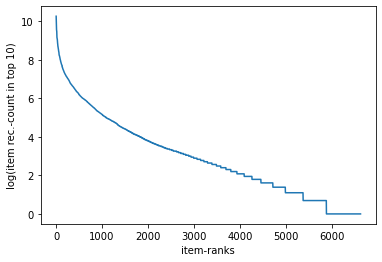

In [ ]:
#plot log of recommendation per item
x=list(reversed(sorted(recommendations.items(), key=lambda x: x[1])))
import math
y=[math.log(e[1]) for e in x]
names=[e[0] for e in x]
import matplotlib.pyplot as plt
plt.plot(y)
plt.ylabel('log(item rec.-count in top 10)')
plt.xlabel('item-ranks')
plt.show()

In [ ]:

a=y_pred.getrow(0).toarray()
from scipy.sparse import find
shape = (sessions_df['user_id'].max() +1, len(cons_group_dic))

y_true = create_sparse_matrix(sessions_df, column='future', shape=shape)    

# print history future and recommendations for the first 50 users
for user_id in range(0,50):
  listofhis=[]
  listofuser=[]
  history_of_user=sessions_df.loc[sessions_df['user_id']==user_id].history.item()
  print("\n\nuser :{} history books".format(user_id))

  for book in history_of_user:
    real_id=(list(cons_group_dic.keys())[book])

    title=books_df_g.loc[books_df_g['group_id'] == real_id].title.item()
    # author=books_df.loc[books_df_g['book_id'] == real_id].author_name.item()
    publisher=books_df_g.loc[books_df_g['group_id'] == real_id].publisher.item()
    listofhis.append(title)

    print("title: {} publisher: {}".format(title,publisher))

  print("\n\nuser :{} future books".format(user_id))
  for i in find(y_true[user_id])[1]:
    real_id=(list(cons_group_dic.keys())[i])
    title=books_df_g.loc[books_df_g['group_id'] == real_id].title.item()
    # author=books_df.loc[books_df_g['book_id'] == real_id].author_name.item()
    publisher=books_df_g.loc[books_df_g['group_id'] == real_id].publisher.item()
    

    print("title: {} publisher: {}".format(title,publisher))
    listofuser.append(title)
  print("\n \nuser :{} predicted books".format(user_id))

  # print the predicted books
  for i in find(y_pred[user_id])[1]:
    real_id=(list(cons_group_dic.keys())[i])
    title=books_df_g.loc[books_df_g['group_id'] == real_id].title.item()
    # author=books_df.loc[books_df_g['book_id'] == real_id].author_name.item()
    publisher=books_df_g.loc[books_df_g['group_id'] == real_id].publisher.item()

    print("title: {} publisher: {}".format(title,publisher))
    if title in listofuser:
      print("         user hit found user {}".format(user_id))
    if title in listofhis:
      print("                   historyhit found his of user {}".format(user_id))
  print("\n\n")

[0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 5, 5]
[3, 1, 1, 1, 1, 7, 15, 13, 30, 28, 18, 29, 47, 51, 40, 43, 58, 53, 92, 91]


user :0 history books
title: Kare Kano: His and Her Circumstances Vol. publisher: {'', 'TokyoPop', 'tokyopop', 'Tokyopop'}
title: Kare Kano: His and Her Circumstances Vol. publisher: {'', 'TokyoPop', 'tokyopop', 'Tokyopop'}
title: Kare Kano: His and Her Circumstances Vol. publisher: {'', 'TokyoPop', 'tokyopop', 'Tokyopop'}
title: Kare Kano: His and Her Circumstances Vol. publisher: {'', 'TokyoPop', 'tokyopop', 'Tokyopop'}
title: Yotsuba&! Vol. (Yotsuba&! #7) publisher: {'', 'Kurokawa', 'Elex Media Komputindo', 'TOKYOPOP', 'PT Elex Media Komputindo', 'PT. Elex Media Komputindo', 'Yen Press', 'ADV Manga'}
title: Kare Kano: His and Her Circumstances Vol. publisher: {'', 'TokyoPop', 'tokyopop', 'Tokyopop'}
title: Kare Kano: His and Her Circumstances Vol. publisher: {'', 'TokyoPop', 'tokyopop', 'Tokyopop'}
title: Kare Kano: His and Her Circumstances Vol. 